## Key Components
1. **State Management**: Using TypedDict to define and manage the state of each customer interaction.
2. **Query Categorization**: Classifying customer queries into Technical, Billing, or General categories.
3. **Sentiment Analysis**: Determining the emotional tone of customer queries.
4. **Response Generation**: Creating appropriate responses based on the query category and sentiment.
5. **Escalation Mechanism**: Automatically escalating queries with negative sentiment to human agents.
6. **Workflow Graph**: Utilizing LangGraph to create a flexible and extensible workflow.

## Method Details
1. **Initialization**: Set up the environment and import necessary libraries.
2. **State Definition**: Create a structure to hold query information, category, sentiment, and response.
3. **Node Functions**: Implement separate functions for categorization, sentiment analysis, and response generation.
4. **Graph Construction**: Use StateGraph to define the workflow, adding nodes and edges to represent the support process.
5. **Conditional Routing**: Implement logic to route queries based on their category and sentiment.
6. **Workflow Compilation**: Compile the graph into an executable application.
7. **Execution**: Process customer queries through the workflow and retrieve results.

In [13]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph

In [14]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from IPython.display import display, Image

In [15]:

class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str
    human_approved: bool
    feedback: str


**Search**

**LLM**

In [16]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature=0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)
result = llm.invoke("What is langchain")
result.content

"LangChain is an open-source framework designed to help developers build applications that utilize large language models (LLMs) more efficiently. It was created to simplify the process of integrating LLMs into various projects, making it easier for developers to focus on building their applications rather than worrying about the underlying infrastructure.\n\nLangChain provides a set of tools and libraries that enable developers to:\n\n1. **Interact with LLMs**: LangChain offers a unified interface to interact with different LLMs, such as LLaMA, PaLM, and others, allowing developers to switch between models seamlessly.\n2. **Manage memory and caching**: LangChain includes features to manage memory and caching, which helps to reduce the computational resources required to run LLMs and improves overall performance.\n3. **Implement indexing and retrieval**: LangChain provides tools for indexing and retrieving data from LLMs, making it easier to store and retrieve information generated by t

**Node Functions**

In [17]:
def categorize(state: State) -> State:
  "Technical, Billing, General"
  prompt = ChatPromptTemplate.from_template(
      "Categorize the following customer query into one of these categories: "
      "Technical, Billing, General. Query: {query}"
  )
  chain = prompt | llm
  category = chain.invoke({"query": state["query"]}).content
  return {"category": category}

# ------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------------------------------------------------------------- #

def analyze_sentiment(state: State) -> State:
  prompt = ChatPromptTemplate.from_template(
      "Analyze the sentiment of the following customer query"
      "Response with either 'Position', 'Neutral' , or 'Negative'. Query: {query}"
  )
  chain = prompt | llm
  sentiment = chain.invoke({"query": state["query"]}).content
  return {"sentiment": sentiment}

# ------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------------------------------------------------------------- #

def handle_technical(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a technical support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

# ------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------------------------------------------------------------- #

def handle_billing(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a billing support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}


# ------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------------------------------------------------------------- #

def handle_general(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a general support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

# ------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------------------------------------------------------------- #


def escalate(state: State)->State:
  return {"response": "This query has been escalate to a human agent due to its negative sentiment"}

# ------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------------------------------------------------------------- #

#human review
def human_review(state: State) -> State:
    """Simulated human review function"""
    print("\nHuman Review Required")
    print(f"Query: {state['query']}")
    print(f"Category: {state['category']}")
    print(f"Sentiment: {state['sentiment']}")
    print(f"Proposed Response: {state['response']}\n")

    approval = input("Approve response? (yes/no): ").lower().strip()
    feedback = ""
    if approval != "yes":
        feedback = input("Please provide feedback or corrections: ")

    return {
        "human_approved": approval == "yes",
        "feedback": feedback
    }

# ------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------------------------------------------------------------- #

# New function for revising responses
def revise_response(state: State) -> State:
    """Revise response based on human feedback"""
    if state["human_approved"]:
        return state

    prompt = ChatPromptTemplate.from_template(
        "Please revise this customer support response based on the feedback provided.\n"
        "Original Response: {response}\n"
        "Feedback: {feedback}\n"
        "Provide a revised response."
    )
    chain = prompt | llm
    revised_response = chain.invoke({
        "response": state["response"],
        "feedback": state["feedback"]
    }).content

    return {"response": revised_response}

# ------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------------------------------------------------------------- #

def route_query(state: State)->State:
  if state["sentiment"] == "Negative":
    return "escalate"
  elif state["category"] == "Technical":
    return "handle_technical"
  elif state["category"] == "Billing":
    return "handle_billing"
  else:
    return "handle_general"

# ------------------------------------------------------------------------------------------------------- #
# ------------------------------------------------------------------------------------------------------- #

# New routing function for revision
def should_revise(state: State) -> str:
    """Determine if response needs revision"""
    return "revise_response" if not state["human_approved"] else "end"


**Create and Configure the graph**

In [18]:
# Create and configure the workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)
workflow.add_node("human_review", human_review)
workflow.add_node("revise_response", revise_response)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)

# Add human review edges
workflow.add_edge("handle_technical", "human_review")
workflow.add_edge("handle_billing", "human_review")
workflow.add_edge("handle_general", "human_review")
workflow.add_edge("escalate", "human_review")

# Add conditional edges for revision
workflow.add_conditional_edges(
    "human_review",
    should_revise,
    {
        "revise_response": "revise_response",
        "end": END
    }
)
workflow.add_edge("revise_response", "human_review")

# Set entry point
workflow.set_entry_point("categorize")

# Compile the workflow
app = workflow.compile()

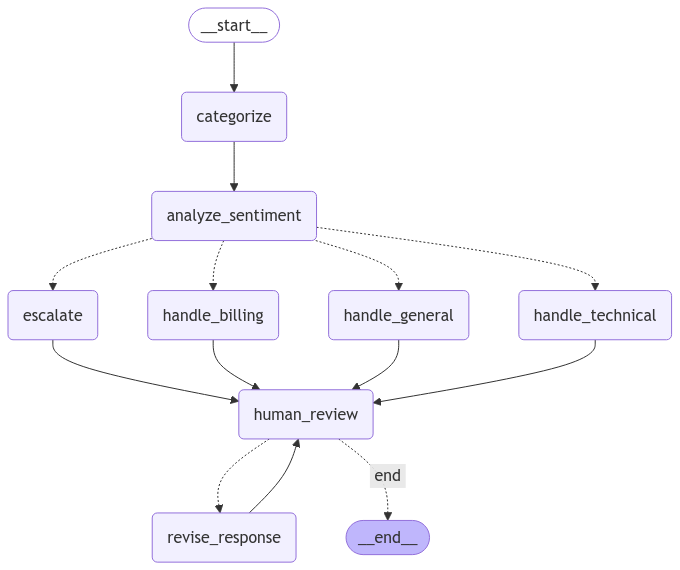

In [19]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

**Customer Support Function**

In [20]:
def run_customer_support(query: str) -> Dict[str, str]:
    results = app.invoke({
        "query": query,
        "human_approved": False,
        "feedback": ""
    })
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"],
        "human_approved": results["human_approved"],
        "feedback": results["feedback"]
    }

In [21]:
# Test cases for different query types

def test_support_agent():
    # Test Case 1: Technical Query
    print("\n=== Test Case 1: Technical Query ===")
    query = "My internet connection is not working and I need help fixing it"
    print(f"Testing query: {query}")
    result = run_customer_support(query)
    print("\nFinal Result:")
    print(f"Category: {result['category']}")
    print(f"Sentiment: {result['sentiment']}")
    print(f"Response: {result['response']}")
    print(f"Human Approved: {result['human_approved']}")
    if result['feedback']:
        print(f"Feedback: {result['feedback']}")




# Run the tests
if __name__ == "__main__":
    print("Starting Customer Support Agent Tests...")
    test_support_agent()

Starting Customer Support Agent Tests...

=== Test Case 1: Technical Query ===
Testing query: My internet connection is not working and I need help fixing it

Human Review Required
Query: My internet connection is not working and I need help fixing it
Category: The customer query "My internet connection is not working and I need help fixing it" would be categorized as: Technical.

This is because the query is related to a technical issue with the customer's internet connection, and they are seeking assistance to resolve the problem.
Sentiment: Neutral. 

Although the customer is experiencing an issue, the tone of the query is informative and seeking help, rather than expressing frustration or anger, which would be characteristic of a Negative sentiment. There is also no explicit expression of satisfaction or appreciation, which would be characteristic of a Positive sentiment. The customer is simply stating their problem and requesting assistance, resulting in a Neutral sentiment.
Propo